In [2]:
import logging
logging.captureWarnings(True)
import deepsensor.torch
# import deepsensor.tensorflow  
from deepsensor.data import DataProcessor, TaskLoader
from deepsensor.model import ConvNP
from deepsensor.train import Trainer

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm import notebook

In [3]:
from deepsensor.train import set_gpu_default_device
set_gpu_default_device()

In [4]:
dat15 ='/nfs/turbo/seas-dannes/SST-sensor-placement-input/GLSEA3_NETCDF/GLSEA3_2015.nc'
dat14 ='/nfs/turbo/seas-dannes/SST-sensor-placement-input/GLSEA3_NETCDF/GLSEA3_2014.nc'
dat16 ='/nfs/turbo/seas-dannes/SST-sensor-placement-input/GLSEA3_NETCDF/GLSEA3_2016.nc'
mask = xr.open_dataset('/home/erinredd/CIGLRProj/lakemask2.nc')


In [5]:
dat = xr.open_mfdataset([dat14, dat15, dat16],
                                concat_dim='time',
                                combine='nested',
                                chunks={'lat': 'auto', 'lon': 'auto'})

In [6]:
# dat16 = dat16.dropna("sst", how="any")
mdat = dat.where(np.isnan(dat.sst) == False, -0.009)
# mdat16 = dat16.where(np.isnan(dat16.sst) == False, -0.009)
# dat = xr.concat([dat15, dat16], dim = 'time')
# mdat = xr.concat([mdat15, mdat16], dim = 'time')

In [7]:
climatology = mdat.groupby('time.dayofyear').mean('time')

In [8]:
anomalies = mdat.groupby('time.dayofyear') - climatology
anomalies

<xarray.Dataset> Size: 4GB
Dimensions:    (time: 1096, lon: 1181, lat: 838)
Coordinates:
  * time       (time) datetime64[ns] 9kB 2014-01-01T12:00:00 ... 2016-12-31T1...
  * lon        (lon) float64 9kB -92.42 -92.41 -92.39 ... -75.91 -75.9 -75.88
  * lat        (lat) float64 7kB 38.87 38.89 38.9 38.92 ... 50.58 50.59 50.61
    dayofyear  (time) int64 9kB 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    sst        (time, lat, lon) float32 4GB dask.array<chunksize=(1, 255, 359), meta=np.ndarray>

## Pre-training

In [9]:
data_processor = DataProcessor(x1_name="lat", x2_name="lon")

In [10]:
# dat_ds = data_processor(dat.sst)
# mdat_ds = data_processor(mdat.sst)
mask_ds = data_processor(mask)

In [11]:
anom_ds = data_processor(anomalies)

In [10]:


# Set placeholders for context and auxiliary data to be determined
# context_data_placeholder = dat  # To be replaced with actual context data
# auxiliary_data_placeholder = None  # To be replaced with actual auxiliary data

task_loader = TaskLoader(
    context = [mdat_ds, mask_ds],
    target = mdat_ds, 
#     aux=auxiliary_data_placeholder
)
print(task_loader)

NameError: name 'mdat_ds' is not defined

In [12]:
task_loader = TaskLoader(
    context = [anom_ds, mask_ds],
    target = anom_ds, 
#     aux=auxiliary_data_placeholder
)

In [17]:
# load model
model = ConvNP(data_processor, task_loader, "../deepsensor_config1/")
# model_loaded

In [14]:
train_tasks = []
for date in pd.date_range('2015-01-02T12:00:00.000000000', '2015-12-31T12:00:00.000000000')[::5]:
#     N_context = np.random.randint(0, 100)
    task = task_loader(date, context_sampling=["all","all"], target_sampling="all")
    train_tasks.append(task)

train_tasks

[time: Timestamp/2015-01-02 12:00:00
 ops: []
 X_c: [('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)'), ('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)')]
 Y_c: ['ndarray/float32/(1, 838, 1181)', 'ndarray/float32/(1, 838, 1181)']
 X_t: [('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)')]
 Y_t: ['ndarray/float32/(1, 838, 1181)'],
 time: Timestamp/2015-01-07 12:00:00
 ops: []
 X_c: [('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)'), ('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)')]
 Y_c: ['ndarray/float32/(1, 838, 1181)', 'ndarray/float32/(1, 838, 1181)']
 X_t: [('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)')]
 Y_t: ['ndarray/float32/(1, 838, 1181)'],
 time: Timestamp/2015-01-12 12:00:00
 ops: []
 X_c: [('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)'), ('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)')]
 Y_c: ['ndarray/float32/(1, 838, 1181)', 'ndarray/float32/(1, 838, 1181)']
 X_t: [('ndarray/float32/(1, 838)', 'ndarray/f

In [15]:
val_tasks = []
for date in pd.date_range('2016-01-01T12:00:00.000000000', '2016-12-31T12:00:00.000000000'):
    N_context = np.random.randint(0, 100)
    task = task_loader(date, context_sampling=["all","all"], target_sampling="all")
    val_tasks.append(task)
    
val_tasks

[time: Timestamp/2016-01-01 12:00:00
 ops: []
 X_c: [('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)'), ('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)')]
 Y_c: ['ndarray/float32/(1, 838, 1181)', 'ndarray/float32/(1, 838, 1181)']
 X_t: [('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)')]
 Y_t: ['ndarray/float32/(1, 838, 1181)'],
 time: Timestamp/2016-01-02 12:00:00
 ops: []
 X_c: [('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)'), ('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)')]
 Y_c: ['ndarray/float32/(1, 838, 1181)', 'ndarray/float32/(1, 838, 1181)']
 X_t: [('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)')]
 Y_t: ['ndarray/float32/(1, 838, 1181)'],
 time: Timestamp/2016-01-03 12:00:00
 ops: []
 X_c: [('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)'), ('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)')]
 Y_c: ['ndarray/float32/(1, 838, 1181)', 'ndarray/float32/(1, 838, 1181)']
 X_t: [('ndarray/float32/(1, 838)', 'ndarray/f

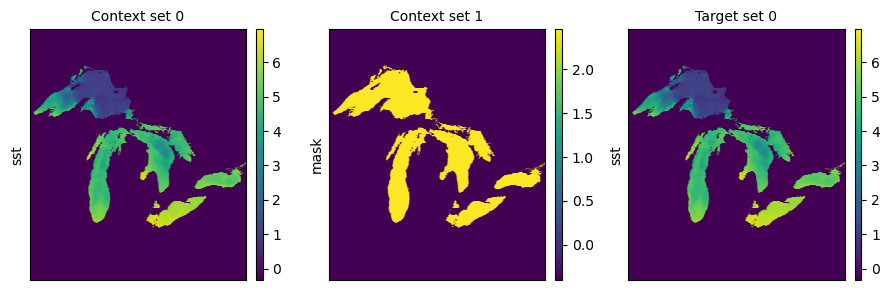

In [15]:
fig = deepsensor.plot.task(train_tasks[200],task_loader)
plt.show()

## Training

In [21]:
data_processor

In [22]:
#frpm deepsensor docu
def compute_val_rmse(model, val_tasks):
    errors = []
    target_var_ID = task_loader.target_var_IDs[0][0]  # assume 1st target set and 1D
    for task in np.random.choice(val_tasks, 50, replace = False):
#         print("im in for loop")
        mean = data_processor.map_array(model.mean(task), target_var_ID, unnorm=True)
#         print("mean calc")
        true = data_processor.map_array(task["Y_t"][0], target_var_ID, unnorm=True)
#         print("true calc")
        errors.extend(np.abs(mean - true))
    return np.sqrt(np.mean(np.concatenate(errors) ** 2))
def gen_tasks(dates, progress=True):
    tasks = []
    for date in notebook.tqdm(dates, disable=not progress):
#         N_c = np.random.randint(0, 500)
        task = task_loader(date, context_sampling=["all", "all"], target_sampling="all")
        tasks.append(task)
    return tasks

In [16]:
print(f"Model has {deepsensor.backend.nps.num_params(model.model)} parameters")

Model has 1031045 parameters


In [23]:
model = ConvNP(data_processor, task_loader)

dim_yc inferred from TaskLoader: (1, 1)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 1180
encoder_scales inferred from TaskLoader: [0.00042372880852781236, 0.00042372880852781236]
decoder_scale inferred from TaskLoader: 0.000847457627118644


In [24]:
losses = []
val_rmses = []
train_range = pd.date_range('2015-01-02T12:00:00.000000000', '2015-12-31T12:00:00.000000000')
val_range = pd.date_range('2016-01-01T12:00:00.000000000', '2016-12-31T12:00:00.000000000')
deepsensor_folder = "../deepsensor_config/"

In [26]:
val_rmse_best = np.inf
trainer = Trainer(model, lr=5e-5)
for epoch in notebook.tqdm(range(2)):
#     print("step1")
    train_tasks = gen_tasks(pd.date_range(train_range[0], train_range[1])[::5], progress=False)

    batch_losses = trainer(train_tasks)
#     print("step3")
    losses.append(np.mean(batch_losses))
    val_rmses.append(compute_val_rmse(model, val_tasks))
    if val_rmses[-1] < val_rmse_best:
        val_rmse_best = val_rmses[-1]
#         print("step4")
        model.save(deepsensor_folder)
#         print("step5")

  0%|          | 0/2 [00:00<?, ?it/s]

/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c2699240>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c2b90>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c26992d0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c2699240>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c0d30>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c26992d0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.constant.Constant), return_type=typing.Any, impl=<function matmul at 0x14c0c25c0e50>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.constant.Constant), return_type=typing.Any, impl=<function matmul at 0x14c0c2699240>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c0e50>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c0d30>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.triangular.UpperTriangular), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1090>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.triangular.UpperTriangular), return_type=typing.Any, impl=<function matmul at 0x14c0c25c2b90>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1090>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c0e50>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1120>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1090>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.triangular.UpperTriangular), return_type=typing.Any, impl=<function matmul at 0x14c0c25c11b0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.triangular.UpperTriangular), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1090>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c11b0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1120>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.constant.Constant), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1240>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.constant.Constant), return_type=typing.Any, impl=<function matmul at 0x14c0c25c0e50>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1240>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c11b0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.triangular.UpperTriangular), return_type=typing.Any, impl=<function matmul at 0x14c0c25c12d0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.triangular.UpperTriangular), return_type=typing.Any, impl=<function matmul at 0x14c0c25c11b0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c12d0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1240>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.triangular.LowerTriangular), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1360>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.triangular.LowerTriangular), return_type=typing.Any, impl=<function matmul at 0x14c0c25c0d30>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1360>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c12d0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c16c0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1360>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.diagonal.Diagonal), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1750>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.diagonal.Diagonal), return_type=typing.Any, impl=<function matmul at 0x14c0c26992d0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1750>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c16c0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.lowrank.LowRank), return_type=typing.Any, impl=<function matmul at 0x14c0c25c17e0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.lowrank.LowRank), return_type=typing.Any, impl=<function matmul at 0x14c0c25c16c0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c17e0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1750>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.triangular.LowerTriangular), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1870>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.triangular.LowerTriangular), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1360>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1870>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c17e0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.lowrank.LowRank), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1900>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.lowrank.LowRank), return_type=typing.Any, impl=<function matmul at 0x14c0c25c17e0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1900>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1870>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.triangular.UpperTriangular), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1990>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.triangular.UpperTriangular), return_type=typing.Any, impl=<function matmul at 0x14c0c25c12d0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1990>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1900>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1b40>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1990>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.woodbury.Woodbury), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1bd0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.woodbury.Woodbury), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1b40>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1bd0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1b40>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.diagonal.Diagonal), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1c60>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.diagonal.Diagonal), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1750>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1c60>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1bd0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.woodbury.Woodbury), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1cf0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.woodbury.Woodbury), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1bd0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1cf0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1c60>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.constant.Constant), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1d80>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.constant.Constant), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1240>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1d80>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1cf0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.woodbury.Woodbury), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1e10>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.woodbury.Woodbury), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1cf0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1e10>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1d80>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.lowrank.LowRank), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1ea0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.lowrank.LowRank), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1900>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1ea0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1e10>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.woodbury.Woodbury), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1f30>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.woodbury.Woodbury), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1e10>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1f30>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1ea0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.triangular.LowerTriangular), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1fc0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.triangular.LowerTriangular), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1870>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1fc0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1f30>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.woodbury.Woodbury), return_type=typing.Any, impl=<function matmul at 0x14c0c25c2050>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.woodbury.Woodbury), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1f30>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c2050>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1fc0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.triangular.UpperTriangular), return_type=typing.Any, impl=<function matmul at 0x14c0c25c20e0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.triangular.UpperTriangular), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1990>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c20e0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c2050>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c2680>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c20e0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.constant.Constant), return_type=typing.Any, impl=<function matmul at 0x14c0c25c2710>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.constant.Constant), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1d80>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c2710>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c2680>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.kronecker.Kronecker), return_type=typing.Any, impl=<function matmul at 0x14c0c25c27a0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.kronecker.Kronecker), return_type=typing.Any, impl=<function matmul at 0x14c0c25c2680>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c27a0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c2710>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.lowrank.LowRank), return_type=typing.Any, impl=<function matmul at 0x14c0c25c2830>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.lowrank.LowRank), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1ea0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c2830>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c27a0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.kronecker.Kronecker), return_type=typing.Any, impl=<function matmul at 0x14c0c25c28c0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.kronecker.Kronecker), return_type=typing.Any, impl=<function matmul at 0x14c0c25c27a0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c28c0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c2830>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.woodbury.Woodbury), return_type=typing.Any, impl=<function matmul at 0x14c0c25c2950>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.woodbury.Woodbury), return_type=typing.Any, impl=<function matmul at 0x14c0c25c2050>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c2950>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c28c0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.kronecker.Kronecker), return_type=typing.Any, impl=<function matmul at 0x14c0c25c29e0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.kronecker.Kronecker), return_type=typing.Any, impl=<function matmul at 0x14c0c25c28c0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c29e0>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c2950>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.triangular.LowerTriangular), return_type=typing.Any, impl=<function matmul at 0x14c0c25c2a70>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.triangular.LowerTriangular), return_type=typing.Any, impl=<function matmul at 0x14c0c25c1fc0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c2a70>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c29e0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(matrix.kronecker.Kronecker), return_type=typing.Any, impl=<function matmul at 0x14c0c25c2b00>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(matrix.kronecker.Kronecker), return_type=typing.Any, impl=<function matmul at 0x14c0c25c29e0>)`.
  warnings.warn(


/home/erinredd/deepsensor_env_gpu/lib/python3.10/site-packages/plum/resolver.py:269: MethodRedefinitionWarning: `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c2b00>)` overwrites the earlier definition `Method(function_name='matmul', signature=Signature(), return_type=typing.Any, impl=<function matmul at 0x14c0c25c2a70>)`.
  warnings.warn(


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(losses)
axes[1].plot(val_rmses)
_ = axes[0].set_xlabel("Epoch")
_ = axes[1].set_xlabel("Epoch")
_ = axes[0].set_title("Training loss")
_ = axes[1].set_title("Validation RMSE")

In [20]:
pred_val = model.predict(val_tasks, X_t = dat) 

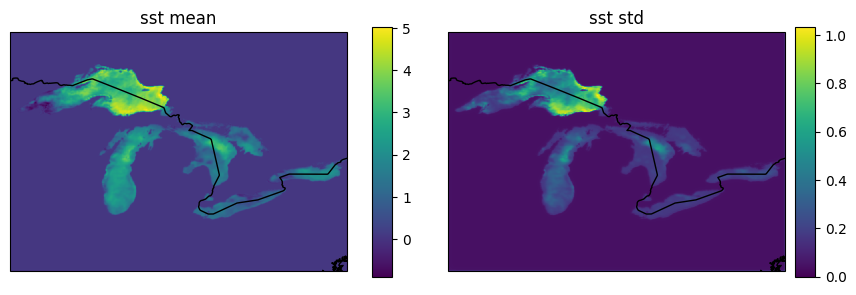

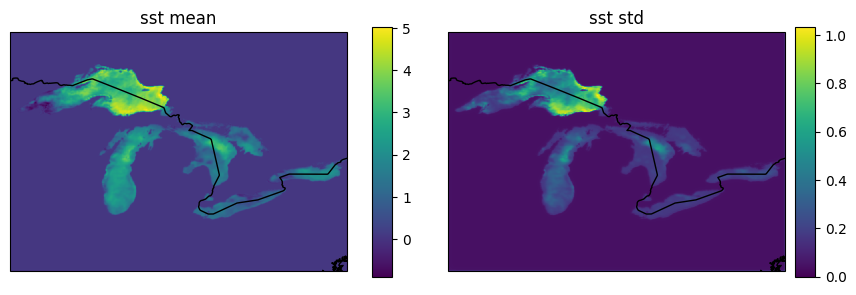

In [39]:
deepsensor.plot.prediction(pred_val, "2016-07-19T12:00:00.000000000",data_processor, task_loader, crs=ccrs.PlateCarree())

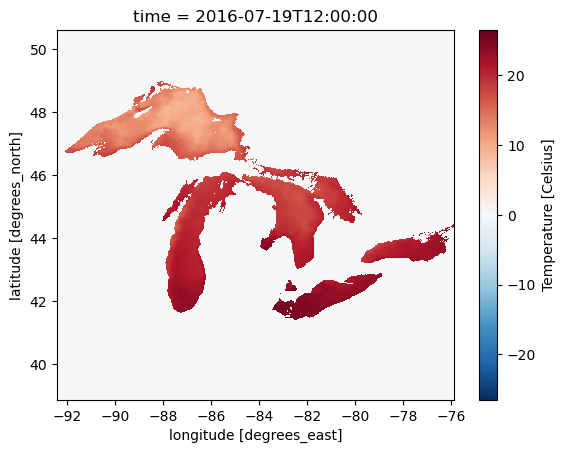

In [61]:
mdat.sst.sel(time = "2016-07-19T12:00:00.000000000").plot()

In [21]:
predxr = pred_val['sst']
predxr = predxr.rename({'mean':'mn','std': 'sd'})
predxr

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 366, lat: 838, lon: 1181)
Coordinates:
  * lat      (lat) float64 7kB 38.87 38.89 38.9 38.92 ... 50.58 50.59 50.61
  * lon      (lon) float64 9kB -92.42 -92.41 -92.39 ... -75.91 -75.9 -75.88
  * time     (time) datetime64[ns] 3kB 2016-01-01T12:00:00 ... 2016-12-31T12:...
Data variables:
    mn       (time, lat, lon) float32 1GB -0.1186 -0.05674 ... -0.1805 -0.2756
    sd       (time, lat, lon) float32 1GB 0.3536 0.3034 0.2588 ... 0.2404 0.2933

In [24]:
y = predxr.mn.where(mask.mask != 0)

Text(0.5, 1.0, 'Mean of Prediction')

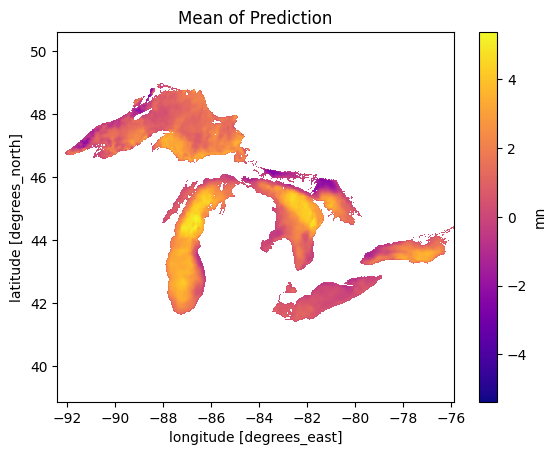

In [38]:
y.isel(time = 180).plot(cmap = "plasma")
plt.title("Mean of Prediction")

In [33]:
x = predxr.sd.where(mask.mask != 0)


Text(0.5, 1.0, 'Standard Deviation of Prediction')

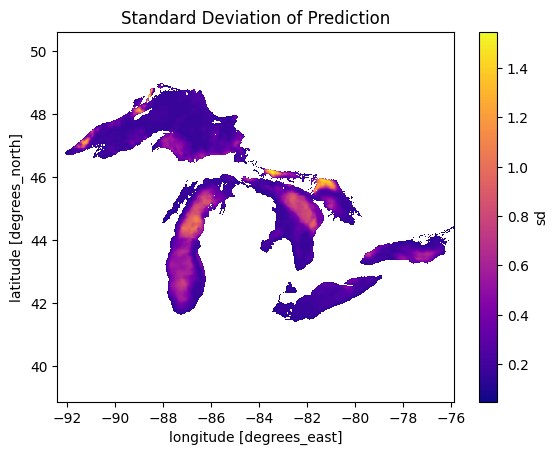

In [37]:
x.isel(time = 180).plot(cmap = "plasma")
plt.title("Standard Deviation of Prediction")

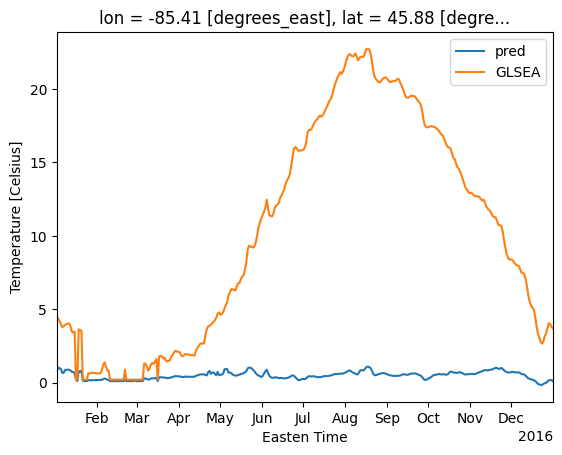

In [31]:
predxr.mn.isel(lat = 500, lon = 500).plot(label = 'pred')
mdat.sst.isel(lat = 500, lon = 500).plot(label = 'GLSEA')
plt.xlim(pd.to_datetime("2016-01-2T12:00:00.000000000"), pd.to_datetime("2016-12-31T12:00:00.000000000"))
plt.legend()
#using 

Text(0.5, 1.0, 'standard deviation')

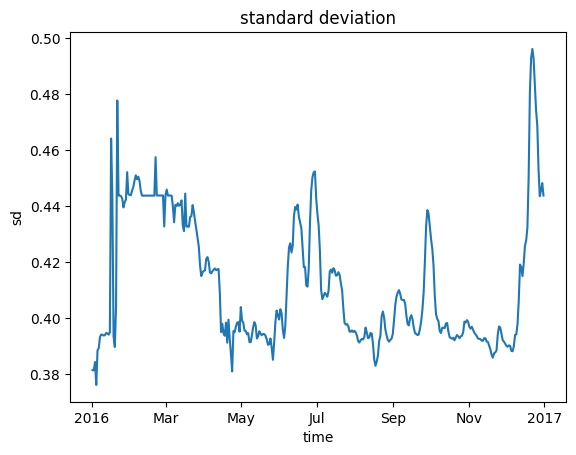

In [32]:
predxr.sd.isel(lat = 500, lon = 500).plot(label = 'pred')
plt.title("standard deviation")

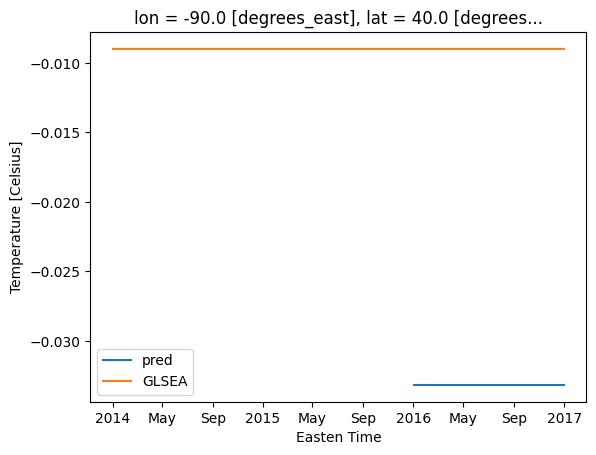

In [33]:
predxr.mn.sel(lat = 40, lon = -90, method = 'nearest').plot(label = 'pred')
mdat.sst.sel(lat = 40, lon = -90, method = 'nearest').plot(label = 'GLSEA')
plt.legend()

Text(0.5, 1.0, 'standard deviation at lat = 40 lon = -90')

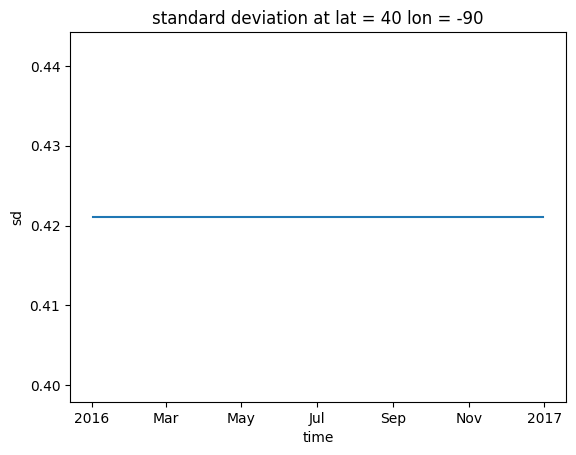

In [36]:
predxr.sd.sel(lat = 40, lon = -90, method = 'nearest').plot(label = 'pred')
plt.title("standard deviation at lat = 40 lon = -90")

In [35]:
test_task = task_loader("2016-07-19T12:00:00.000000000", ["all", "all"], seed_override=42)
pred = model.predict(test_task, X_t=mask, n_samples=3, ar_sample=True, ar_subsample_factor=10)

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.25 GiB. GPU 

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), subplot_kw={"projection": ccrs.PlateCarree()})
for sample_i, ax in enumerate(axes):
    (pred["sst"][f"sample_{sample_i}"] - pred["sst"].mn).plot(ax=ax, cmap="seismic", center=0., add_colorbar=False)
    ax.coastlines()
deepsensor.plot.offgrid_context(axes, test_task, data_processor, task_loader, linewidth=0.5)
plt.show()